### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File 'RGBNIR_DSM_CHM_VIf_v4.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr"
```
- last commands will install julia libraries, necessary to run the notebook.
- 
- To visualize the results install Jinja2
```bash
conda install jinja2
```

### Running PySR 

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
import skill_metrics as sm
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

### Set up PySR run:


NDVIc scenario

In [5]:
df = pd.read_csv(r"E:\Github\PySR_ATeam_sac\examples\LAI_vineyard_equations\Data\03_df_bands_structure_VI_LAI_transect.csv")
# print(df.head())
X = df.iloc[:,1:-2]
y = df.LAI
print(X.head())
# X.head()

        Red     Green      Blue       NIR        FC   c_depth        CH  \
0  0.061897  0.062535  0.008709  0.299303  0.439236  1.429447  1.972603   
1  0.068177  0.064934  0.008982  0.301526  0.383681  1.474576  1.946317   
2  0.072847  0.064652  0.009800  0.288310  0.274306  1.550626  1.988539   
3  0.076038  0.069866  0.010479  0.291893  0.307292  1.559624  2.024439   
4  0.078895  0.068669  0.010746  0.289200  0.130208  1.447568  1.946801   

        AVI        BAI       BCC  ...       TGI       TVI      TriVI  \
0  0.405463  17.030671  0.065416  ...  3.251827  1.075765  14.269864   
1  0.403232  16.849939  0.063211  ...  3.243666  1.063570  13.871250   
2  0.386184  18.916874  0.066534  ...  3.004268  1.047182  12.599963   
3  0.387566  18.399806  0.067007  ...  3.347232  1.042435  12.704379   
4  0.382636  18.875765  0.067882  ...  3.117494  1.035052  12.209277   

       VARI       VIG   VgNIRBI   VrNIRBI     NDVIf    TSAVIm     TSAVIg  
0  0.005512  0.005126 -0.654350 -0.657271

The default parameters will help speed up code and ensure repeteability of run

In [6]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= "L2DistLoss()",  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [7]:
# Learn equations
model = PySRRegressor(
    niterations=10000000,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=3600*24,  # this line will make the code stop after 2 hours
    binary_operators=["+", "*","-","/"], # these are the default binary operators (use these for basic equations)
    # binary_operators=["+", "*","-","/","nd(x,y) = ((x-y)/(x+y))", "sr(x,y)=x/y"], # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    # unary_operators=["sqrt", "exp", "log", "inv(x)=1/x"], # other basic operators can be added here
    # extra_sympy_mappings={"inv": lambda x: 1 / x,"nd": lambda x, y: ((x- y)/(x+y)),"sr": lambda x, y: x/y}, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)

c:\Users\A02424951\AppData\Local\anaconda3\envs\pySR\Lib\site-packages\pysr\sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\A02424951\AppData\Local\anaconda3\envs\pySR\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


,model_selection,'best'
,binary_operators,"['+', '*', ...]"
,unary_operators,None
,expression_spec,None
,niterations,10000000
,populations,31
,population_size,27
,max_evals,None
,maxsize,50
,maxdepth,None
,warmup_maxsize_by,None


In [8]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           2.367226   
	1         0.325454                                      3.435736 / CH   
	2         0.202856                              2.5135381 / (CH - FC)   
	3         0.102069                      (NIR + FC) * (4.7386155 / CH)   
	4         0.070571             ((NIR + (RGRI * FC)) / CH) * 4.8603044   
	5         0.024665  (NIR + FC) * ((12.39998 / (CH + NDVI)) - 2.460...   
	6         0.011645  (((15.4773035 / (CH + DSWI4)) + DSWI4) - 3.933...   
	7         0.010197  ((((14.853946 - c_depth) / (CH + DSWI4)) + DSW...   
	8         0.007741  ((DSWI4 + (((-0.014184116 / FC) + 15.759735) /...   
	9         0.011904  (DSWI4 + (((((-0.0146801835 / FC) - c_depth) +...   
	10        0.013146  ((RCC + (FC * 3.9983199)) + (16.10829 / (((c_d...   
	11        0.025353  GBNDVI + (((17.677132 / ((((c_depth + c_depth)...   
	12      

We can print the model pareto curve, which will showcase the trend of discovered solutions:

complexity                                  3
loss                                 0.673516
equation                        3.435736 / CH
score                                0.325454
sympy_format                      3.435736/CH
lambda_format    PySRFunction(X=>3.435736/CH)
Name: 1, dtype: object
Best equation found (optimal balance between complexity and loss):


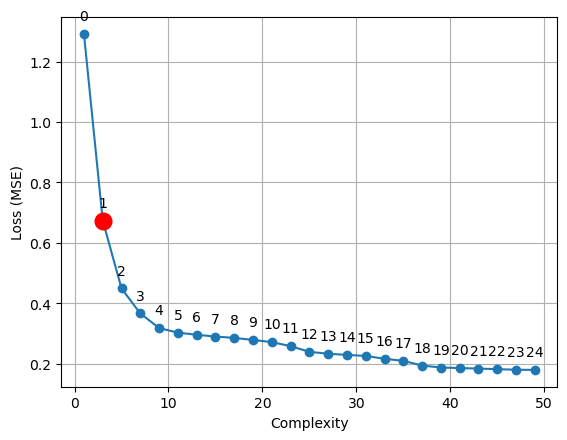

In [ ]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
max_index = scores.idxmax(axis=0)
max_index


# Get the index of the equation chosen by model_selection
selected_index = model.equations_.index[model.equations_["selected"]].tolist()[0]

print("Selected equation index:", selected_index)

pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [23]:
model.sympy()

FC + (10.356291 - 0.09905589/FC)/(BAI + (c_depth*(-BAI*FC + BAI) - 1*2.4079359)*(CH*MRBVI*(CH - FC - 1.9017856) + c_depth)*4.911213) + 1.6967226/CH

In [ ]:
model.sympy(18)  # get the 10th equation in sympy format

FC + (10.356291 - 0.09905589/FC)/(BAI + (c_depth*(-BAI*FC + BAI) - 1*2.4079359)*(CH*MRBVI*(CH - FC - 1.9017856) + c_depth)*4.911213) + 1.6967226/CH

In this run, Eq 1 was the best, so:

In [11]:
model.sympy(17)

CH*(FC - 0.27362937) + (7.819715 - 0.079419754/FC)/(BAI + (c_depth*2.1122751*BAI - SR2)*(BCC + CH*(CH - 2.3565423) + c_depth)) + 2.0454676/CH

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [19]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291319,2.367226
1,0.673516,3.435736 / CH
2,0.448900,2.5135381 / (CH - FC)
3,0.366011,(NIR + FC) * (4.7386155 / CH)
4,0.317831,((NIR + (RGRI * FC)) / CH) * 4.8603044
5,0.302533,(NIR + FC) * ((12.39998 / (CH + NDVI)) - 2.4606664)
6,0.295569,(((15.4773035 / (CH + DSWI4)) + DSWI4) - 3.9335616) * (FC + NIR)
7,0.289602,((((14.853946 - c_depth) / (CH + DSWI4)) + DSWI4) - 3.3027802) * (FC + NIR)
8,0.285152,((DSWI4 + (((-0.014184116 / FC) + 15.759735) / (DSWI4 + CH))) - 4.020885) * (FC + NIR)
9,0.278444,(DSWI4 + (((((-0.0146801835 / FC) - c_depth) + 15.146434) / (CH + DSWI4)) - 3.3932557)) * (NIR + FC)


## Output

Plotting the first solutions

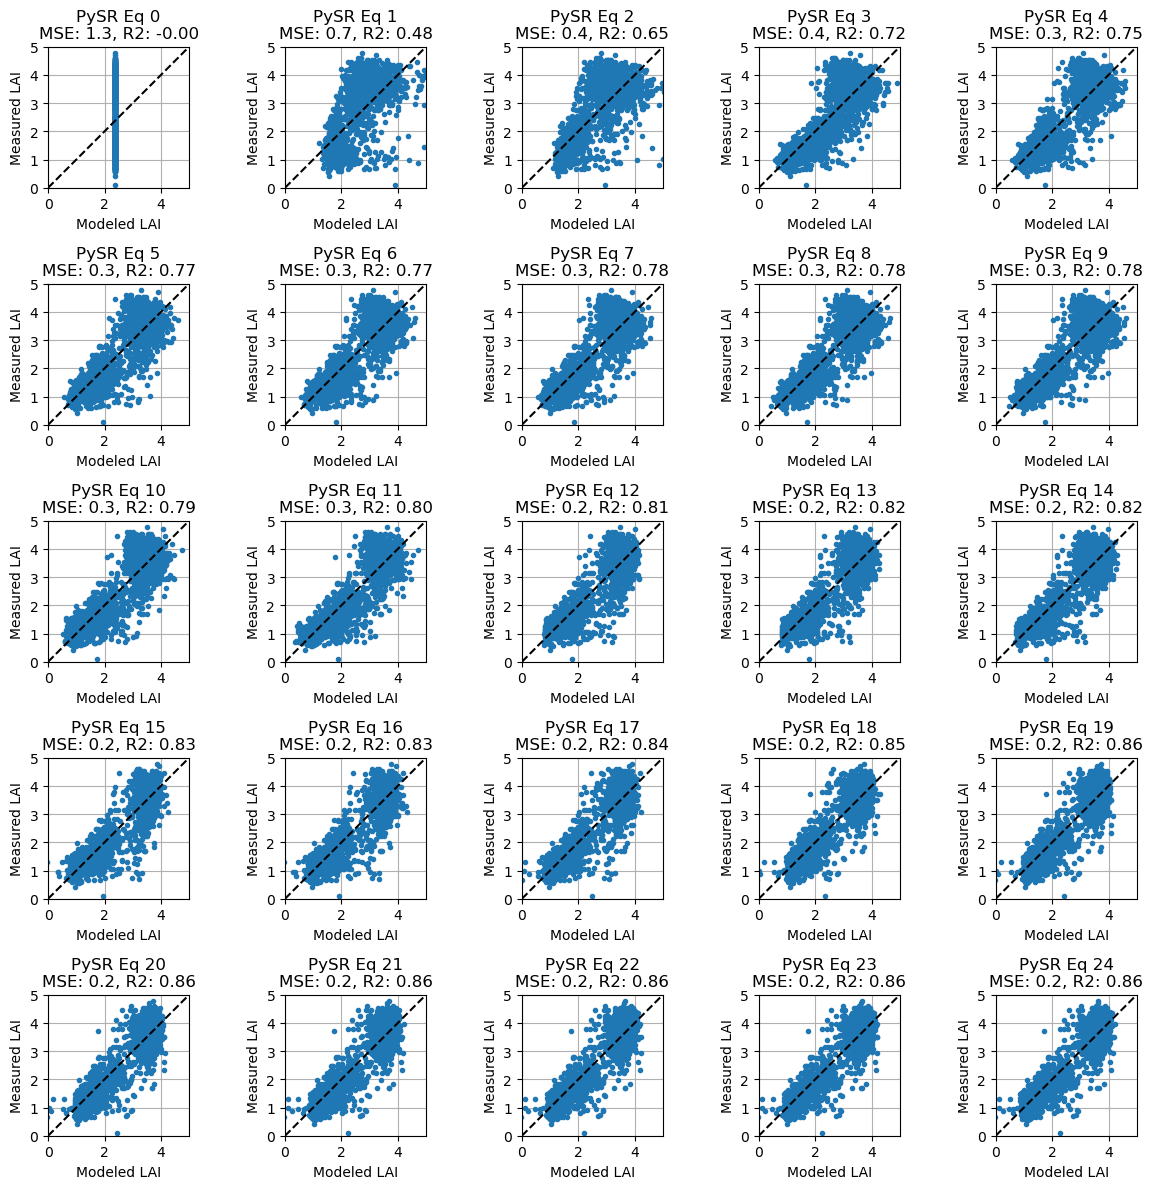

In [20]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

it = np.linspace(0,25,26, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(ypredict_simpler, y,'.')
    ax.grid(True)
    ax.set_xlabel("Modeled LAI")
    ax.set_ylabel("Measured LAI")
    ax.plot( [0,5], [0,5], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    mse =np.power(ypredict_simpler - y, 2).mean()
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



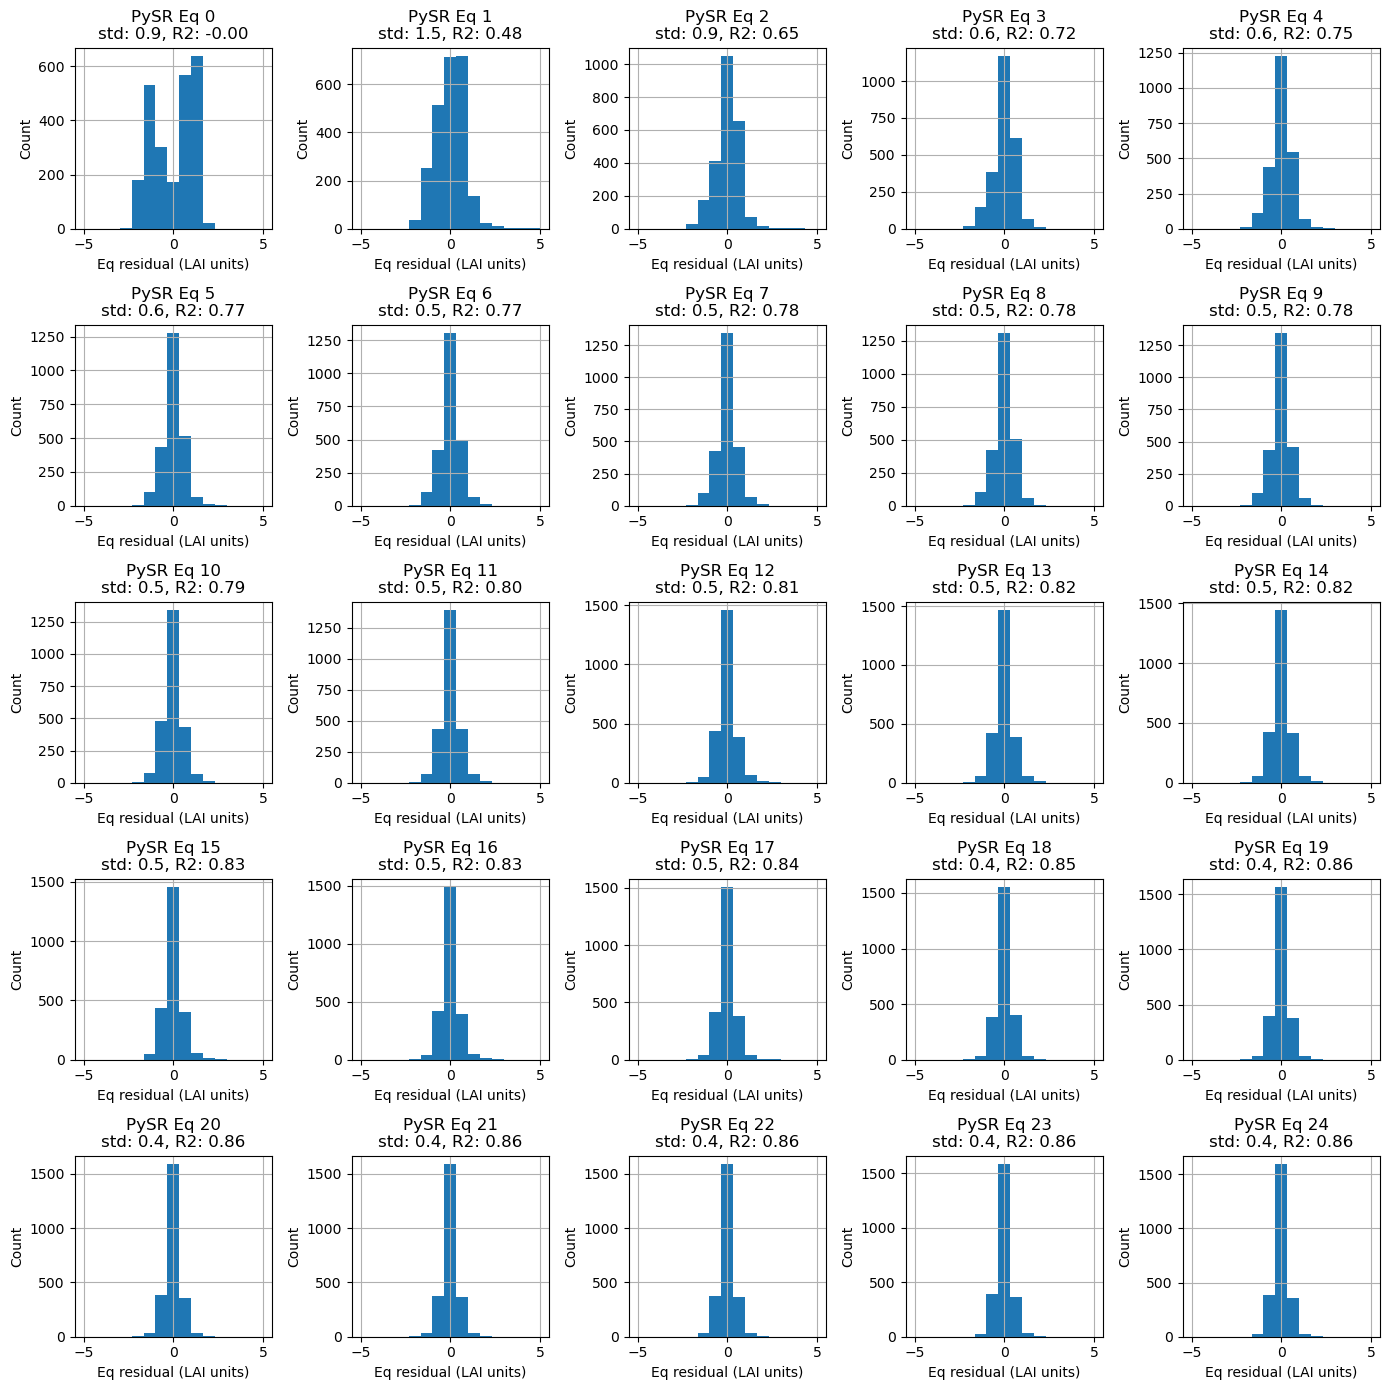

In [21]:
fig, axes = plt.subplots(5, 5, figsize=(14, 14))

it = np.linspace(0,25,26, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y,range=(-5,5), bins=15)
    ax.grid(True)
    ax.set_xlabel("Eq residual (LAI units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )

    # ax.set_aspect('equal')
    # ax.set_xlim(0, 70)
    # ax.set_ylim(0, 70)
    std =np.std(np.power(ypredict_simpler - y, 2)).mean()
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Create a Taylor diagram with labeled data points and modified axes

c:\Users\A02424951\AppData\Local\anaconda3\envs\pySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\A02424951\AppData\Local\anaconda3\envs\pySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


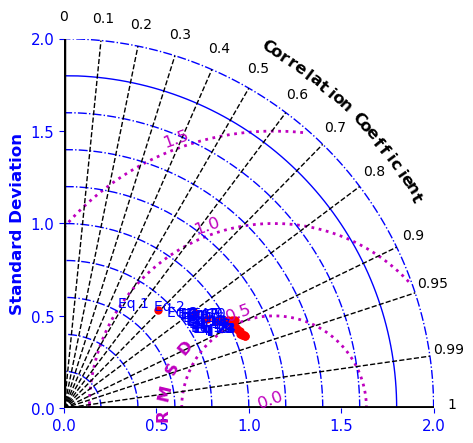

In [22]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api